# <font style="color:blue">Project 3: Object Detection</font>


#### Maximum Points: 100

<div>
    <table>
        <tr><td><h3>Sr. no.</h3></td> <td><h3>Section</h3></td> <td><h3>Points</h3></td> </tr>
        <tr><td><h3>1</h3></td> <td><h3>Plot Ground Truth Bounding Boxes</h3></td> <td><h3>20</h3></td> </tr>
        <tr><td><h3>2</h3></td> <td><h3>Training</h3></td> <td><h3>25</h3></td> </tr>
        <tr><td><h3>3</h3></td> <td><h3>Inference</h3></td> <td><h3>15</h3></td> </tr>
        <tr><td><h3>4</h3></td> <td><h3>COCO Detection Evaluation</h3></td> <td><h3>25</h3></td> </tr>
        <tr><td><h3>5</h3></td> <td><h3>Run Inference on a Video</h3></td> <td><h3>15</h3></td> </tr>
    </table>
</div>


# <font style="color:purple">Download the Dataset</font> 

**[Download the Vehicle registration plate](https://www.dropbox.com/s/k81ljpmzy3fgtx9/Dataset.zip?dl=1)**


Download the Vehicle Registration Plate dataset from [here](https://www.dropbox.com/s/k81ljpmzy3fgtx9/Dataset.zip?dl=1) and unzip it. 

We will have the following directory structure:

```
Dataset
├── train
│   └── Vehicle registration plate
│       └── Label
└── validation
    └── Vehicle registration plate
        └── Label
```

Unzipping the file will give you a directory `Dataset`. This directory has two folder `train` and `validation`. Each train and validation folder has `Vehicle registration plate`  folder with `.jpg` images and a folder `Labels`.  `Labels` folder has bounding box data for the images.


For example,
For image: `Dataset/train/Vehicle registration plate/bf4689922cdfd532.jpg`
Label file is  `Dataset/train/Vehicle registration plate/Label/bf4689922cdfd532.txt`

There are one or more lines in each `.txt` file. Each line represents one bounding box.
For example,
```
Vehicle registration plate 385.28 445.15 618.24 514.225
Vehicle registration plate 839.68 266.066462 874.24 289.091462
```

We have a single class detection (`Vehicle registration plate detection`) problem. So bounding box details start from the fourth column in each row.

Representation is in `xmin`, `ymin`, `xmax`, and `ymax` format.

**It has `5308` training and `386` validation dataset.**

Data is downloaded from [Open Images Dataset](https://storage.googleapis.com/openimages/web/index.html)

In [1]:
%matplotlib inline

In [2]:
from logging import config
# import matplotlib
# matplotlib.use('TkAgg') # or 'Qt5Agg', 'GTK3Agg', 'WXAgg'
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
import os
import matplotlib.pyplot as plt
import yaml
import pickle
import torch

# model_zoo has lots of pre-trained models
from detectron2 import model_zoo

# DefaultTrainer is a class for training object detector
from detectron2.engine import DefaultTrainer
# DefaultPredictor is class for inference
from detectron2.engine import DefaultPredictor

# detectron2 has its configuration format
from detectron2.config import get_cfg
# detectron2 has implemented Visualizer of object detection
from detectron2.utils.visualizer import Visualizer

# from DatasetCatalog, detectron2 gets dataset and from MetadatCatalog it gets metadata of the dataset
from detectron2.data import DatasetCatalog, MetadataCatalog

# BoxMode supports bounding boxes in different format
from detectron2.structures import BoxMode

# COCOEvaluator based on COCO evaluation metric, inference_on_dataset is used for evaluation for a given metric
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

# build_detection_test_loader, used to create test loader for evaluation
from detectron2.data import build_detection_test_loader

/home/rama/anaconda3/envs/ml_base/lib/python3.10/site-packages/detectron2/model_zoo/model_zoo.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [3]:
def load_config():
    """Load configuration from YAML files."""
    with open('configs/paths.yaml', 'r') as f:
        paths_config = yaml.safe_load(f)
    return paths_config

def setup_config(training_config, project_config):
    """
    Setup detectron2 configuration.
    
    Args:
        training_config: Path to training config file
        project_config: Project configuration dictionary from YAML
        
    Returns:
        detectron2 cfg object
    """
    
    if not os.path.exists(training_config):
        raise FileNotFoundError(f"Configuration file {training_config} not found.")
    
    # Load base config from detectron2 model zoo
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
    
    # Merge custom config from YAML
    cfg.merge_from_file(training_config)
    
    
    # Set model weights from pretrained checkpoint
    # cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_50_FPN_3x.yaml")
    
    # Update output directory
    with open(training_config, 'r') as f:
        training_configconfig = yaml.safe_load(f)
    cfg.OUTPUT_DIR = os.path.join(project_config['OUTPUT']['MODEL_DIR'], training_configconfig['OUTPUT_DIR'])
    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    cfg.freeze()
    
    print(f"Configuration loaded from: {training_config}")
    print(f"Output directory: {cfg.OUTPUT_DIR}")
    
    return cfg, training_configconfig['OUTPUT_DIR']


In [4]:
def prepare_pjt3_dataset(dataroot):
    """
    Prepare dataset in detectron2 format.
    
    Args:
        dataroot: Root path to the dataset
        
    Returns:
        List of dataset dictionaries in detectron2 format
    """
    if not os.path.exists(dataroot):
        print(f"Data root path {dataroot} does not exist.")
        return []
    
    dataroot = os.path.join(dataroot, 'Vehicle registration plate')
    # Data root contains images with name as ID, a folder "Labels" contains annotation of number plates in txt files.
    # file name format: <image_id>.txt
    # Each annotation file contain multiple lines, each line contains:
    # <Vehicle> <registration> <plate> <x_min> <y_min> <x_max> <y_max>
    
    data_set_dicts = []
    bberror = False  # Flag to indicate bounding box error
    
    # Loop through all image files in the dataroot
    for img_filename in os.listdir(dataroot):
        if not img_filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue
  
        record = {}
        image_id = os.path.splitext(img_filename)[0]
        img_path = os.path.join(dataroot, img_filename)
        height, width = cv2.imread(img_path).shape[:2]
        
        record["file_name"] = img_path
        record["image_id"] = image_id
        record["height"] = height
        record["width"] = width
        
        annos = []
        label_file_path = os.path.join(dataroot, "Label", f"{image_id}.txt")
        if os.path.exists(label_file_path):
            with open(label_file_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) == 7:
                        x_min, y_min, x_max, y_max = map(float, parts[3:7])
                        obj = {
                            "bbox": [x_min, y_min, x_max, y_max],
                            "bbox_mode": BoxMode.XYXY_ABS,
                            "category_id": 0,  # single class 'number_plate'
                            "iscrowd": 0
                        }
                        annos.append(obj)
                        # do basic validation of bbox
                        if x_min < 0 or y_min < 0 or x_max > width or y_max > height:
                            print(f"Warning: Bounding box out of image bounds in file {label_file_path}")
                            bberror = True
        
        record["annotations"] = annos
        if bberror:
            print(f"Skipping image {img_path} due to bounding box errors.")
            bberror = False  # Reset the flag for next image
            continue
        data_set_dicts.append(record)
    
    return data_set_dicts


def load_or_prepare_dataset(config):
    """Load cached dataset or prepare new one."""
    cache_dir = config['CACHE']
    train_pkl = cache_dir['TRAIN_DICT_FILE']
    test_pkl = cache_dir['TEST_DICT_FILE']
    train_data_root = config['DATA']['TRAIN_ROOT']
    test_data_root = config['DATA']['TEST_ROOT']
    
    if not os.path.exists(train_pkl) or not os.path.exists(test_pkl):
        print("Preparing dataset dicts...")
        train_data_set_dict = prepare_pjt3_dataset(train_data_root)
        test_data_set_dict = prepare_pjt3_dataset(test_data_root)
        
        # Save the dataset dicts for future use
        with open(train_pkl, 'wb') as f:
            pickle.dump(train_data_set_dict, f)
        with open(test_pkl, 'wb') as f:
            pickle.dump(test_data_set_dict, f)
        print(f"Dataset dicts saved to {train_pkl} and {test_pkl}")
    else:
        print(f"Loading dataset dicts from cache...")
        with open(train_pkl, 'rb') as f:
            train_data_set_dict = pickle.load(f)
        with open(test_pkl, 'rb') as f:
            test_data_set_dict = pickle.load(f)
    
    return train_data_set_dict, test_data_set_dict

def register_datasets(train_data_set_dict, test_data_set_dict):
    """Register datasets with detectron2."""
    DatasetCatalog.register("pjt3_train", lambda: train_data_set_dict)
    MetadataCatalog.get("pjt3_train").set(thing_classes=["number_plate"])
    
    DatasetCatalog.register("pjt3_test", lambda: test_data_set_dict)
    MetadataCatalog.get("pjt3_test").set(thing_classes=["number_plate"])
    
    return MetadataCatalog.get("pjt3_test")



In [5]:
def train_model(cfg, tf_events_dir):
    """
    Train the RetinaNet model.
    
    Args:
        cfg: detectron2 configuration object
        tf_events_dir: Directory to store TensorFlow events
    """
    print("\n" + "="*60)
    print("PART 2: Training RetinaNet on custom dataset")
    print("="*60)
    print(f"TensorFlow events being saved to: {tf_events_dir}")
    
    trainer = DefaultTrainer(cfg)
    trainer.resume_or_load(resume=True)
    trainer.train()
    
    print("\nTraining completed!")
    print(f"Model checkpoints saved to: {cfg.OUTPUT_DIR}")


In [6]:
# ===== Extra: Video read and write function =====
def video_read_write(cfg, config, pjt3_metadata,video_path):
    """
    Read video frames one-by-one, flip it, and write in the other video.
    video_path (str): path/to/video
    """
    video = cv2.VideoCapture(video_path)
    
    # Check if camera opened successfully
    if not video.isOpened(): 
        print("Error opening video file")
        return
    
    # create video writer
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frames_per_second = video.get(cv2.CAP_PROP_FPS)
    num_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    
    output_fname = '{}_out.mp4'.format(os.path.splitext(video_path)[0])
    
    output_file = cv2.VideoWriter(
        filename=output_fname,
        # some installation of opencv may not support x264 (due to its license),
        # you can try other format (e.g. MPEG)
        fourcc=cv2.VideoWriter_fourcc(*"MPEG"),
        fps=float(frames_per_second),
        frameSize=(width, height),
        isColor=True,
    )
    
    #Inference logic
    
    print("\n" + "="*60)
    print("PART 4: Running inference on video file")
    print("="*60)
    #unfreeze cfg to modify for inference
    cfg.defrost()
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, config['MODEL']['FINAL_WEIGHTS_FILE'])
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = config['MODEL']['SCORE_THRESH_TEST']
    # cfg.DATASETS.TEST = ("pjt3_test",)
    cfg.freeze()
    
    predictor = DefaultPredictor(cfg)
    # dataset_dicts = DatasetCatalog.get("pjt3_test")
    
    i = 0
    while video.isOpened():
        ret, frame = video.read()
        if ret:
            outputs = predictor(frame)
            v = Visualizer(frame[:, :, ::-1],
                           metadata=pjt3_metadata,
                           scale=1.0
            )
            # Draw the prediction with higher confidence score
            #check if there are any instances detected
            if len(outputs["instances"]) == 0:
                print(f"No instances detected in frame {i}")
                output_file.write(frame)
#                 cv2.imwrite('anpd_out/frame_{}.png'.format(str(i).zfill(3)), frame[:, ::-1, :])
                i += 1
                continue
            print(f"Instances detected in frame {i}: {len(outputs['instances'])}")
            out = v.draw_instance_predictions(outputs["instances"].to("cpu")[0])
            frame = out.get_image()[:, :, ::-1]           
            output_file.write(frame)
#             cv2.imwrite('anpd_out/frame_{}.png'.format(str(i).zfill(3)), frame[:, ::-1, :])
            i += 1
        else:
            break
        
    video.release()
    output_file.release()
    
    return


In [7]:
def run_inference(cfg, config, pjt3_metadata):
    """
    Run inference on test dataset.
    
    Args:
        cfg: detectron2 configuration object
        config: Configuration dictionary from YAML
        pjt3_metadata: Metadata for visualization
    """
    print("\n" + "="*60)
    print("PART 3: Running inference on test dataset")
    print("="*60)
    #unfreeze cfg to modify for inference
    cfg.defrost()
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, config['MODEL']['FINAL_WEIGHTS_FILE'])
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = config['MODEL']['SCORE_THRESH_TEST']
    cfg.DATASETS.TEST = ("pjt3_test",)
    cfg.freeze()
    
    predictor = DefaultPredictor(cfg)
    dataset_dicts = DatasetCatalog.get("pjt3_test")
    
    for d in random.sample(dataset_dicts, min(3, len(dataset_dicts))):
        im = cv2.imread(d["file_name"])
        outputs = predictor(im)
        v = Visualizer(im[:, :, ::-1],
                       metadata=pjt3_metadata,
                       scale=0.5
        )
        # Draw the prediction with higher confidence score
        #check if there are any instances detected
        if len(outputs["instances"]) == 0:
            print(f"No instances detected in image {d['file_name']}")
            continue
        out = v.draw_instance_predictions(outputs["instances"].to("cpu")[0])
        plt.figure(figsize=(15, 10))
        plt.imshow(out.get_image())
        plt.show()
        cv2.waitKey(0)
        # pause = input("Press Enter to continue to next image...")
        
        
        plt.axis('off')
        plt.tight_layout()
        output_path = f"prediction_{d['file_name'].split('/')[-1]}"
        output_dir = os.path.join(config['OUTPUT']['INFERENCE_DIR'])
        os.makedirs(output_dir, exist_ok=True)
        output_path = os.path.join(output_dir, output_path)
        plt.savefig(output_path, dpi=150, bbox_inches='tight')
        plt.close()
        print(f"Saved prediction image to {output_path}")
    
    print("Inference completed!")
    return predictor


In [8]:
def evaluate_model(cfg, config, predictor):
    """
    Evaluate model using COCO metrics.
    
    Args:
        cfg: detectron2 configuration object
        config: Configuration dictionary from YAML
        predictor: DefaultPredictor object
    """
    print("\n" + "="*60)
    print("PART 4: Evaluating model using COCO metrics")
    print("="*60)
    
    eval_dir = config['OUTPUT']['COCO_EVAL_DIR']
    os.makedirs(eval_dir, exist_ok=True)
    
    evaluator = COCOEvaluator("pjt3_test", cfg, False, output_dir=eval_dir)
    val_loader = build_detection_test_loader(cfg, 'pjt3_test')
    
    print("Starting model evaluation...")
    inference_on_dataset(predictor.model, val_loader, evaluator)
    print("Model evaluation completed.")
    print(f"Evaluation results saved to: {eval_dir}")


In [9]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
import torch
torch.cuda.empty_cache()
training_config = 'configs/faster_rcnn.yaml'
# Load configuration for fixed paths
project_config = load_config()

# ===== Load or Prepare Dataset =====
train_data_set_dict, test_data_set_dict = load_or_prepare_dataset(project_config)

# ===== Register Datasets =====
pjt3_metadata = register_datasets(train_data_set_dict, test_data_set_dict)

# ===== Setup Configuration =====
cfg, output_dir = setup_config(training_config, project_config)


Loading dataset dicts from cache...
Configuration loaded from: configs/faster_rcnn.yaml
Output directory: models/./output_pjt3_faster_rcnn


#  <font style="color:green">1. Plot Ground Truth Bounding Boxes [20 Points]</font> 

**You have to show three images from validation data with the bounding boxes.**

The plotted images should be similar to the following:

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w10-g1.png'>



<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w10-g2.png'>



<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w10-g3.png'>



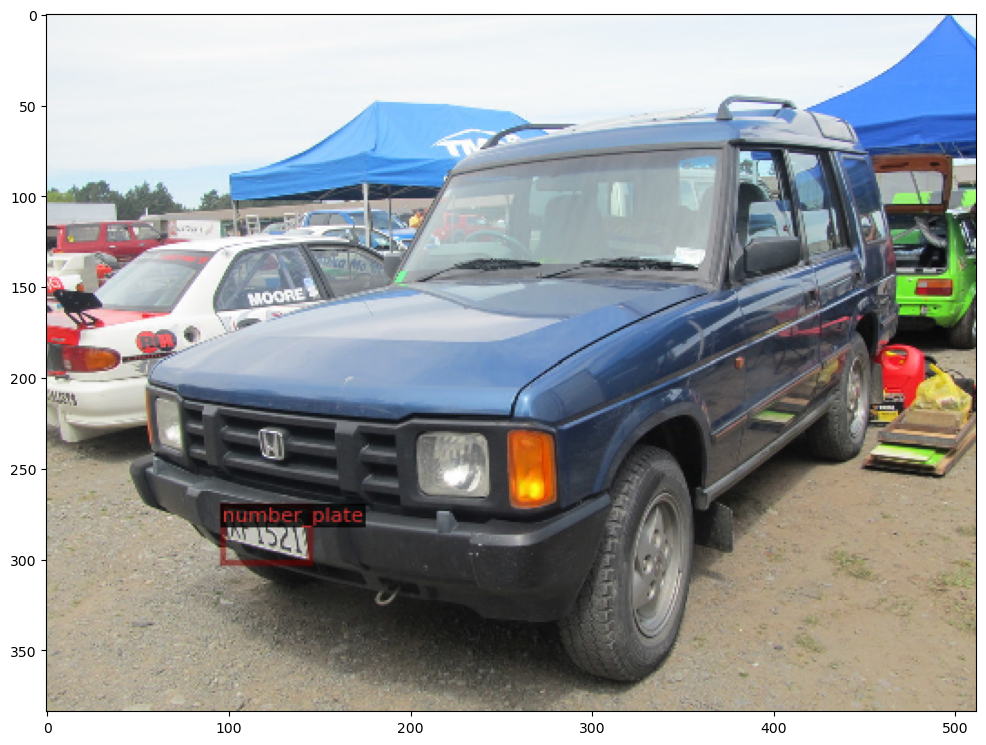

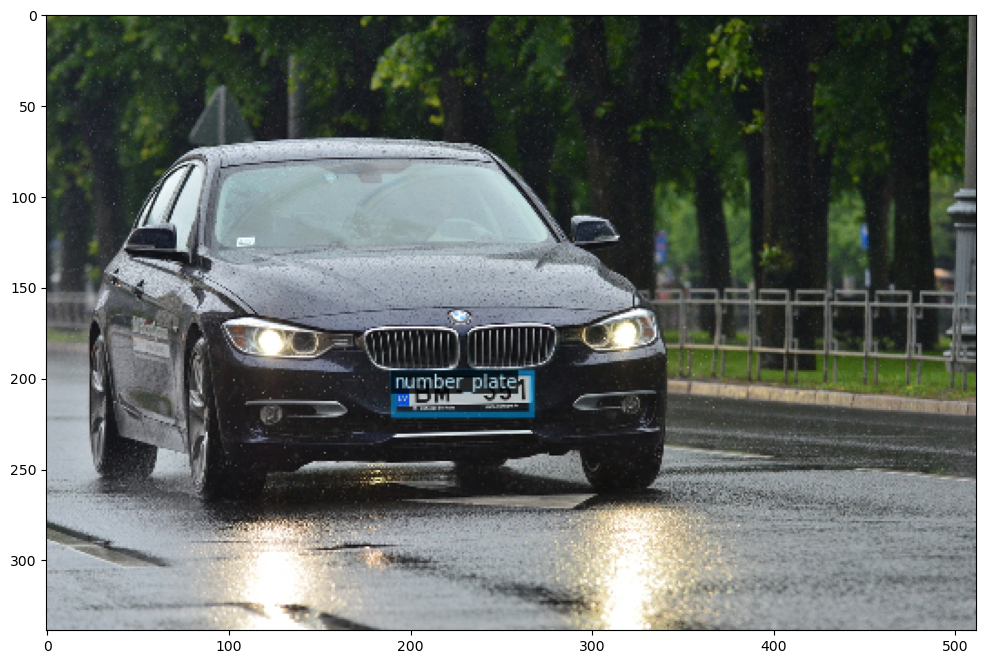

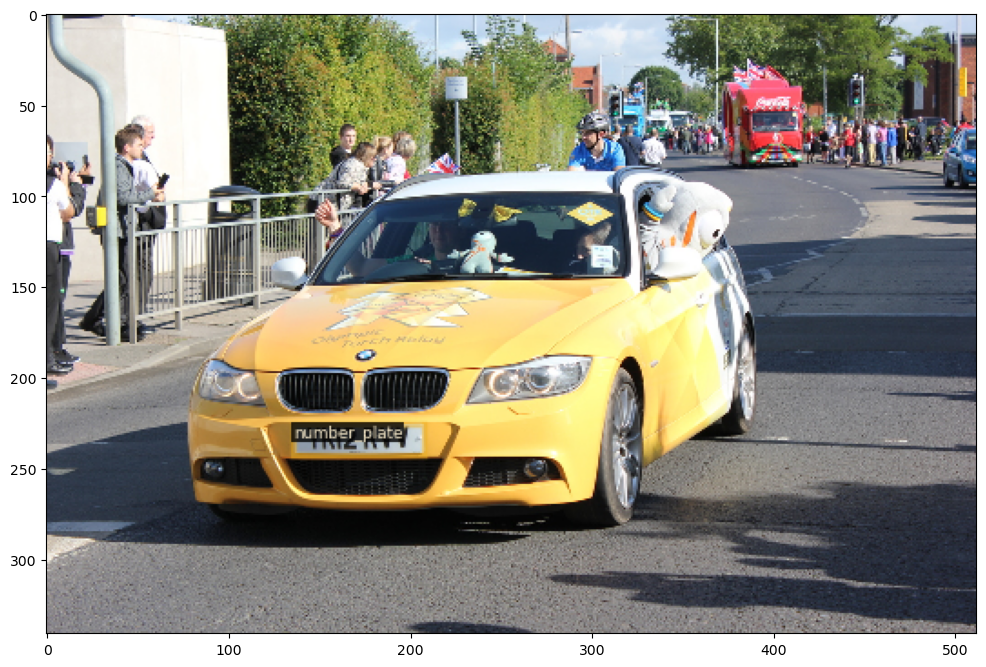

In [10]:
for d in random.sample(test_data_set_dict, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=pjt3_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.figure(figsize=(12,12))
    plt.imshow(out.get_image())
    plt.show()
    

#  <font style="color:green">2. Training [25 Points]</font> 

- **Write your training code in this section.**

- **You also have to share ([shared logs example](https://tensorboard.dev/experiment/JRtnsKbwTaq1ow6nPLPGeg)) the loss plot of your training using tensorboard.dev.** 

How to share TensorBoard logs using tensorboard.dev find [here](https://courses.opencv.org/courses/course-v1:OpenCV+OpenCV-106+2019_T1/courseware/b1c43ffe765246658e537109e188addb/d62572ec8bd344db9aeae81235ede618/4?activate_block_id=block-v1%3AOpenCV%2BOpenCV-106%2B2019_T1%2Btype%40vertical%2Bblock%40398b46ddcd5c465fa52cb4d572ba3229).

In [11]:
tf_events_dir = os.path.join(output_dir, project_config['OUTPUT']['TF_EVENTS_DIR'])
os.makedirs(tf_events_dir, exist_ok=True)
train_model(cfg, tf_events_dir)


PART 2: Training RetinaNet on custom dataset
TensorFlow events being saved to: ./output_pjt3_faster_rcnn/tf_events
[02/04 14:57:36 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), pad

/home/rama/anaconda3/envs/ml_base/lib/python3.10/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_locati

[02/04 14:57:39 d2.engine.hooks]: Loading scheduler from state_dict ...
[02/04 14:57:39 d2.engine.train_loop]: Starting training from iteration 15000
[02/04 14:57:39 d2.engine.hooks]: Total training time: 0:00:00 (0:00:00 on hooks)
[02/04 14:57:39 d2.data.build]: Distribution of instances among all 1 categories:
|   category   | #instances   |
|:------------:|:-------------|
| number_plate | 512          |
|              |              |
[02/04 14:57:39 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(1024, 1024), max_size=1024, sample_style='choice')]
[02/04 14:57:39 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[02/04 14:57:39 d2.data.common]: Serializing 386 elements to byte tensors and concatenating them all ...
[02/04 14:57:39 d2.data.common]: Serialized dataset takes 0.14 MiB
WARNING [02/04 14:57:39 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.te

#  <font style="color:green">3. Inference [15 Points]</font> 

**You have to make predictions from your trained model on three images from the validation dataset.**

The plotted images should be similar to the following:

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w10-p1.png'>



<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w10-p2.png'>



<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w10-p3.png'>





PART 3: Running inference on test dataset
[02/04 14:57:41 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from models/./output_pjt3_faster_rcnn/model_final.pth ...


/home/rama/anaconda3/envs/ml_base/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


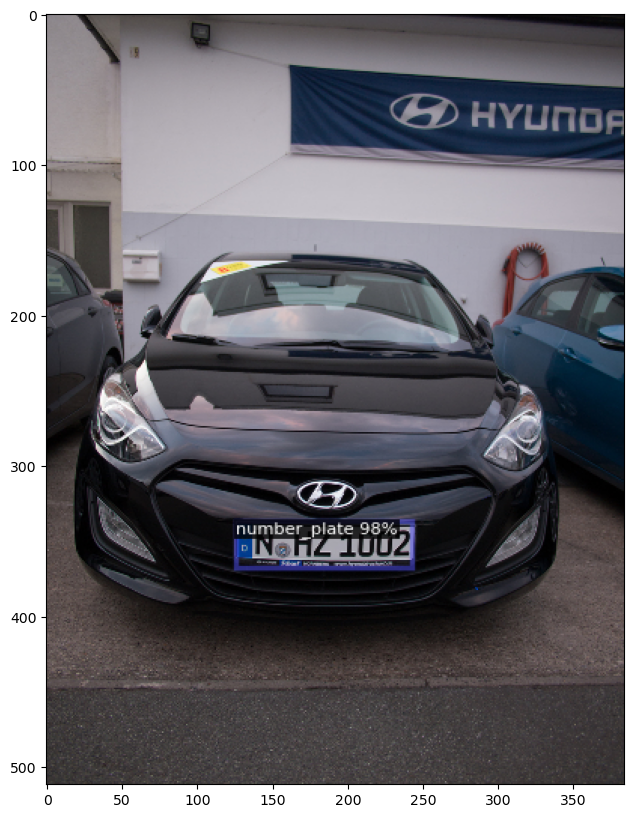

Saved prediction image to inference_results/prediction_1071b237587a698b.jpg


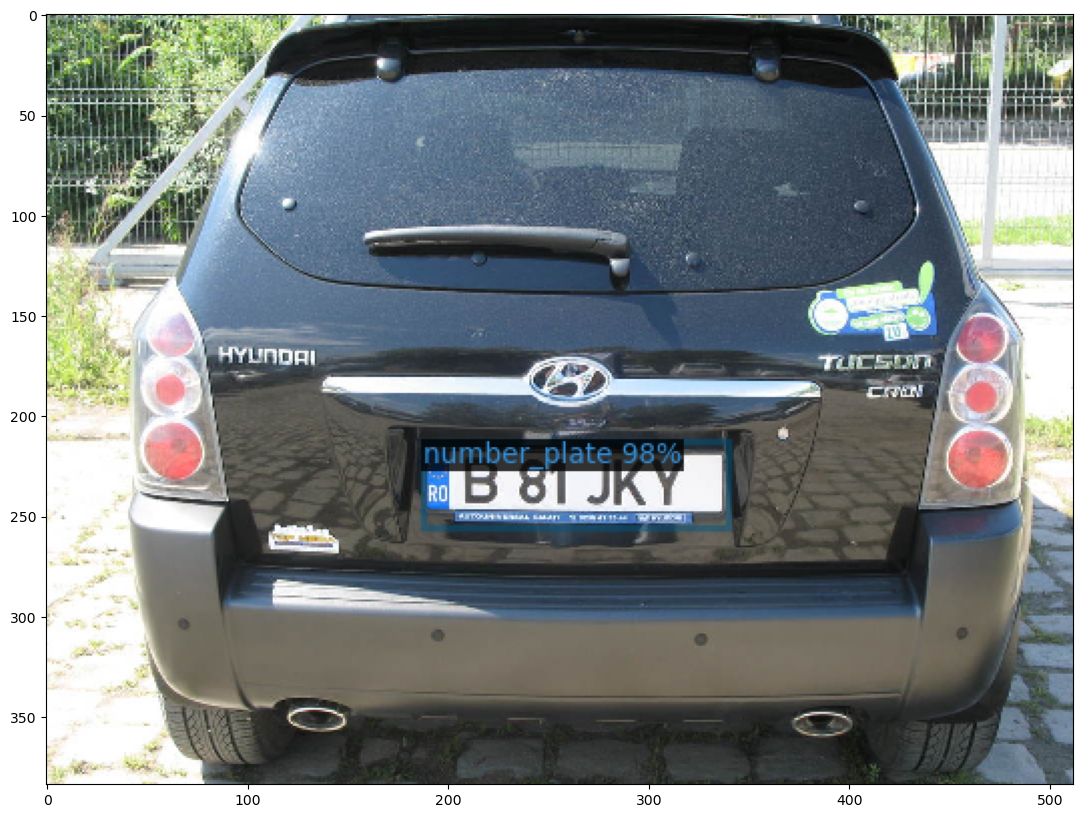

Saved prediction image to inference_results/prediction_80e02a518ffe4cb2.jpg


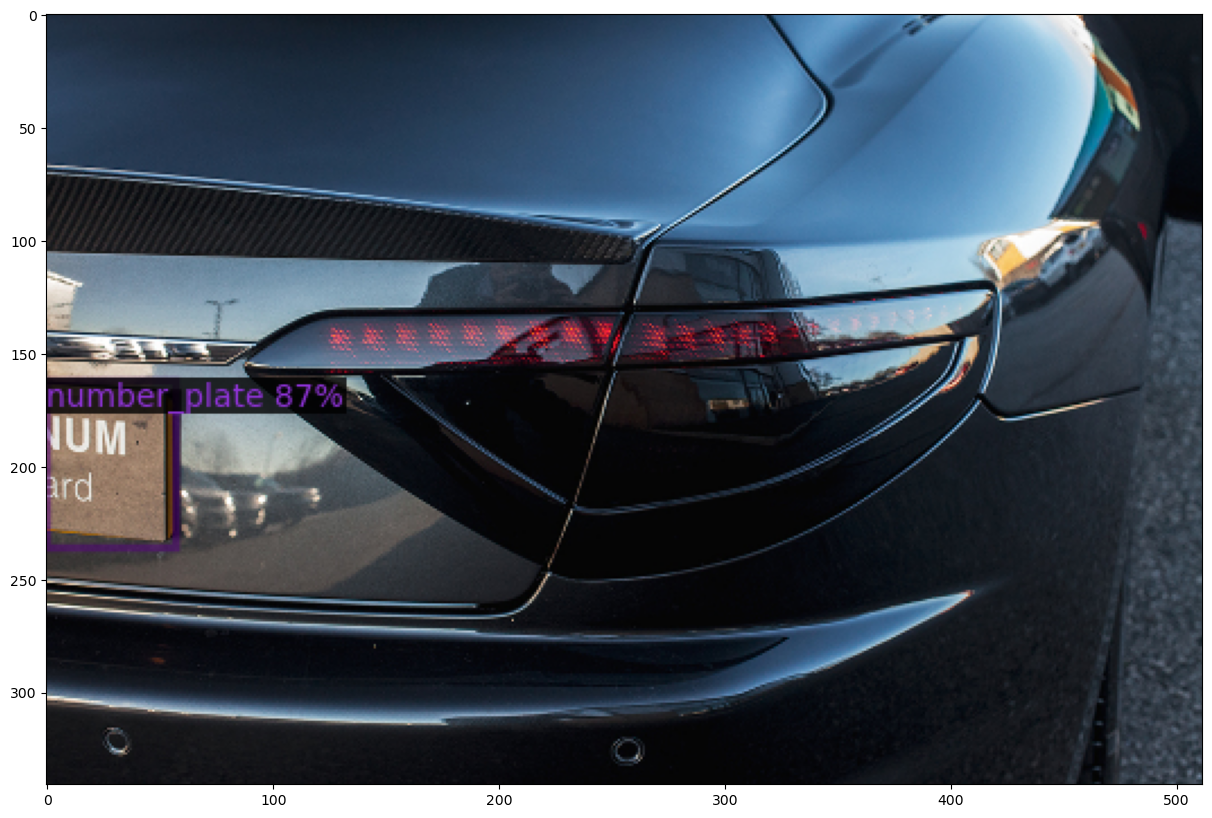

Saved prediction image to inference_results/prediction_66be6b583048fa94.jpg
Inference completed!


In [12]:
predictor = run_inference(cfg, project_config, pjt3_metadata)

#  <font style="color:green">4. COCO Detection Evaluation [25 Points]</font> 

**You have to evaluate your detection model on COCO detection evaluation metric.**

For your reference here is the coco evaluation metric chart:


---

<img src="https://www.learnopencv.com/wp-content/uploads/2020/03/c3-w9-coco_metric.png">

---

#### <font style="color:red">The expected `AP` (primary challenge metric) is more than `0.5`.</font>

**The expected output should look similar to the following:**

```
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.550
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.886
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.629
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.256
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.653
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.627
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.504
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.629
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.633
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.380
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.722
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.704
```



In [13]:
evaluate_model(cfg, project_config, predictor)


PART 4: Evaluating model using COCO metrics
WARNING [02/04 14:57:51 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[02/04 14:57:51 d2.evaluation.coco_evaluation]: Trying to convert 'pjt3_test' to COCO format ...
WARNING [02/04 14:57:51 d2.data.datasets.coco]: Using previously cached COCO format annotations at 'coco_eval/pjt3_test_coco_format.json'. You need to clear the cache file if your dataset has been modified.
[02/04 14:57:51 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(1024, 1024), max_size=1024, sample_style='choice')]
[02/04 14:57:51 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[02/04 14:57:51 d2.data.common]: Serializing 386 elements to byte tensors and concatenating them all ...
[02/04 14:57:51 d2.data.common]: Serialized dataset takes 0.14 MiB
Starting m

# <font style="color:green">5. Run Inference on a Video [15 Points]</font>

#### [Download the Input Video](https://www.dropbox.com/s/g88o4dx18zpgn8k/projet3-input-video.mp4?dl=1)

**You have to run inference on a video.** 

You can download the video from [here](https://www.dropbox.com/s/g88o4dx18zpgn8k/projet3-input-video.mp4?dl=1).

#### <font style="color:red">Upload the output video on youtube and share the link. Do not upload the video in the lab.</font>

In [14]:
video_path = project_config['DATA']['TEST_VIDEO_PATH']
if os.path.exists(video_path):
    video_read_write(cfg, project_config, pjt3_metadata, video_path)
else:
    print(f"Test video path {video_path} does not exist. Skipping video inference.")

print("\n" + "="*60)
print("All processes completed successfully!")
print("="*60)


PART 4: Running inference on video file


OpenCV: FFMPEG: tag 0x4745504d/'MPEG' is not supported with codec id 2 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


[02/04 15:00:52 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from models/./output_pjt3_faster_rcnn/model_final.pth ...


/home/rama/anaconda3/envs/ml_base/lib/python3.10/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_locati

No instances detected in frame 0
No instances detected in frame 1
No instances detected in frame 2
No instances detected in frame 3
No instances detected in frame 4
No instances detected in frame 5
No instances detected in frame 6
No instances detected in frame 7
No instances detected in frame 8
No instances detected in frame 9
No instances detected in frame 10
No instances detected in frame 11
No instances detected in frame 12
No instances detected in frame 13
No instances detected in frame 14
No instances detected in frame 15
No instances detected in frame 16
No instances detected in frame 17
No instances detected in frame 18
No instances detected in frame 19
No instances detected in frame 20
Instances detected in frame 21: 1
Instances detected in frame 22: 1
Instances detected in frame 23: 1
Instances detected in frame 24: 1
Instances detected in frame 25: 1
Instances detected in frame 26: 1
Instances detected in frame 27: 1
Instances detected in frame 28: 1
Instances detected in fr

**Your output video should have a bounding box around the vehicle registration plate.**

https://youtu.be/_uX3r00Wjp0